<a href="https://colab.research.google.com/github/semontoyab-cloud/SYS2025/blob/main/Parcial1SyS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Parcial 1 - Señales y Sistemas - Sebastian Montoya Bedoya **

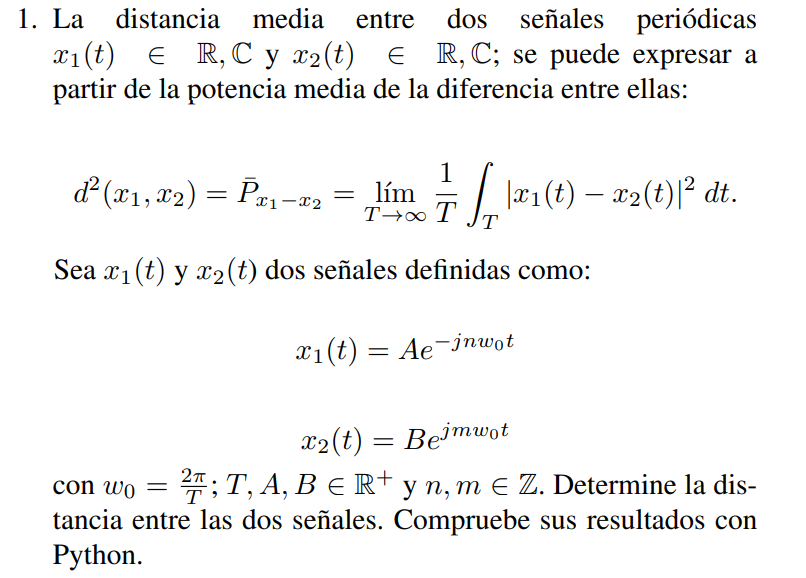

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path


# ---------------------------------------------------------------
# (1) Fórmula analítica demostrada
# ---------------------------------------------------------------
def distancia_analitica(A: float, B: float, n: int, m: int) -> float:
    """
    Devuelve d(x1,x2) para:
        x1(t) = A * e^{-j n w0 t}
        x2(t) = B * e^{j m w0 t}

    Resultado teórico:
        - Si n+m == 0  ->  d = |A - B|
        - Si n+m != 0  ->  d = sqrt(A^2 + B^2)

    Parámetros:
        A, B : amplitudes reales positivas
        n, m : enteros

    Retorna:
        d (float): distancia media (raíz del promedio de |x1-x2|^2)
    """
    return abs(A - B) if (n + m) == 0 else np.sqrt(A**2 + B**2)


# ---------------------------------------------------------------
# (2) Cálculo numérico por integración en un periodo
# ---------------------------------------------------------------
def distancia_numerica(A: float,
                       B: float,
                       n: int,
                       m: int,
                       w0: float,
                       num_muestras: int = 40000):
    """
    Aproxima d(x1,x2) usando la definición:
        d^2 = (1/T0) * ∫_0^{T0} |x1 - x2|^2 dt,
    con T0 = 2*pi/w0.

    Implementación:
        - Construimos una malla temporal uniforme en [0, T0).
        - Evaluamos x1, x2 y |x1 - x2|^2 punto a punto.
        - Integramos con la regla del trapecio (np.trapz).
        - Tomamos la raíz para obtener d.

    Retorna:
        d (float): distancia numérica
        t (ndarray): vector de tiempos (0..T0)
        diff2 (ndarray): valores de |x1 - x2|^2 en t
    """
    T0 = 2 * np.pi / w0
    # Malla temporal. endpoint=False evita repetir el 0 al final.
    t = np.linspace(0.0, T0, num_muestras, endpoint=False)

    # Señales complejas (usar 1j = sqrt(-1) en Python)
    x1 = A * np.exp(-1j * n * w0 * t)
    x2 = B * np.exp(+1j * m * w0 * t)

    # Magnitud al cuadrado de la diferencia
    diff2 = np.abs(x1 - x2) ** 2

    # Promedio temporal (1/T0)*∫ diff2 dt  y raíz
    d2_prom = (1.0 / T0) * np.trapz(diff2, t)
    d = float(np.sqrt(d2_prom))
    return d, t, diff2


# ---------------------------------------------------------------
# (3) Media acumulada: visualiza convergencia del promedio
# ---------------------------------------------------------------
def media_acumulada(t: np.ndarray, y: np.ndarray):
    """
    Calcula la media acumulada de y(t) en [0, t_k]:
        mean_k = (1/t_k) * ∫_0^{t_k} y(τ) dτ
    usando trapecios acumulados.

    Retorna:
        t_mid (ndarray): tiempos asociados a cada promedio acumulado (t[1:])
        mean (ndarray): medias acumuladas en t_mid
    """
    # Integral acumulada por trapecios: (y_i + y_{i+1})/2 * Δt
    dt = np.diff(t)                 # Δt uniforme
    integ_acum = np.cumsum((y[:-1] + y[1:]) * dt / 2.0)
    t_mid = t[1:]                   # tiempos (evitamos t=0 para no dividir por 0)
    mean = integ_acum / t_mid       # media acumulada
    return t_mid, mean


# ---------------------------------------------------------------
# (4) Ejemplos a simular
#    - Mezclamos casos n+m != 0 y n+m == 0
#    - Varios A, B, w0 para observar comportamientos distintos
# ---------------------------------------------------------------
EJEMPLOS = [
    #  (A,   B,   w0,  n,   m,    etiqueta)
    (2.0, 1.5, 5.0,  1,   2,  "Ej.1: n+m != 0"),
    (2.0, 1.5, 5.0,  3,  -3,  "Ej.2: n+m = 0"),
    (1.0, 3.0, 8.0, -2,   5,  "Ej.3: n+m != 0"),
    (2.5, 2.5, 4.0,  7,  -7,  "Ej.4: n+m = 0 y A=B"),
    (0.7, 2.2, 6.0,  0,   3,  "Ej.5: n=0 (DC)"),
]


# ---------------------------------------------------------------
# (5) Punto de entrada: ejecuta todo y guarda resultados
# ---------------------------------------------------------------
def main():
    # Carpeta de salida para archivos (CSV/figuras)
    out_dir = Path("./salidas_distancia")
    out_dir.mkdir(parents=True, exist_ok=True)

    registros = []  # para construir la tabla (DataFrame)

    for (A, B, w0, n, m, tag) in EJEMPLOS:
        # ---- Distancia numérica (definición) ----
        d_num, t, diff2 = distancia_numerica(A, B, n, m, w0, num_muestras=40000)

        # ---- Distancia analítica (fórmula demostrada) ----
        d_ana = distancia_analitica(A, B, n, m)

        # ---- Errores para evaluar la coincidencia ----
        err_abs = abs(d_num - d_ana)
        err_rel = err_abs / (abs(d_ana) + 1e-12)  # protegemos división por cero

        # ---- Guardamos fila para la tabla ----
        registros.append({
            "tag": tag,
            "A": A, "B": B, "w0(rad/s)": w0,
            "n": n, "m": m, "n+m": n+m,
            "d_analitica": d_ana,
            "d_numerica": d_num,
            "error_abs": err_abs,
            "error_rel_%": 100 * err_rel
        })

        # ---- Figura 1: |x1 - x2|^2 en un periodo ----
        plt.figure()
        plt.plot(t, diff2)
        plt.title(f"{tag} — |x1(t) - x2(t)|^2 en un periodo")
        plt.xlabel("t [s]")
        plt.ylabel("|x1 - x2|^2")
        fig1_path = out_dir / f"{tag.replace(' ', '_').replace(':','')}_diff2.png"
        plt.savefig(fig1_path, bbox_inches="tight")
        plt.show()

        # ---- Figura 2: media acumulada (convergencia al promedio) ----
        t_mid, mean_acc = media_acumulada(t, diff2)
        plt.figure()
        plt.plot(t_mid, mean_acc)
        plt.title(f"{tag} — media acumulada de |x1 - x2|^2")
        plt.xlabel("t [s]")
        plt.ylabel("media acumulada de |x1 - x2|^2")
        fig2_path = out_dir / f"{tag.replace(' ', '_').replace(':','')}_mean_acc.png"
        plt.savefig(fig2_path, bbox_inches="tight")
        plt.show()

    # ---- Tabla resumen en DataFrame + export a CSV ----
    df = pd.DataFrame(registros)
    csv_path = out_dir / "resumen_analitico_vs_numerico.csv"
    df.to_csv(csv_path, index=False)

    # Mensaje final en consola con rutas de salida
    print("\n=== RESUMEN ===")
    print(df)
    print(f"\nCSV guardado en: {csv_path.resolve()}")
    print(f"Figuras PNG guardadas en: {out_dir.resolve()}")


# Ejecutar solo si se corre como script (no al importar)
if __name__ == "__main__":
    main()

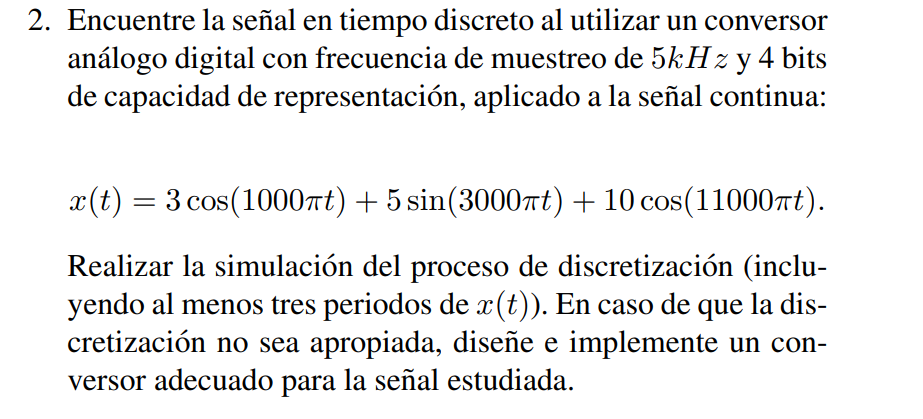

In [ ]:
# ===============================================================
# Ejercicio 2 — Simulación de muestreo y cuantización (ADC)
# ===============================================================
# Señal continua:
#   x(t) = 3 cos(1000π t) + 5 sin(3000π t) + 10 cos(11000π t)
#
# Escenarios:
#   A) fs = 5 kHz  (enunciado; hay alias: 5500 Hz -> 500 Hz)
#   B) fs = 12 kHz (diseño adecuado sin aliasing)
#
# Qué hace:
#   - Dibuja señal "continua" (malla densa) + muestras
#   - Cuantiza con cuantizador uniforme simétrico (mid-tread) de B=4 bits
#   - Grafica muestras vs. cuantizadas
#   - Calcula SQNR aproximado
#   - Guarda CSV si pandas está disponible (opcional)
# ===============================================================

import numpy as np
import matplotlib.pyplot as plt
from math import ceil, floor
from pathlib import Path

# (Pandas es opcional; el script corre sin él)
try:
    import pandas as pd
    PANDAS_OK = True
except Exception:
    PANDAS_OK = False

# ---------------------------
# 1) Señal continua y utilidades
# ---------------------------

def x_cont(t: np.ndarray) -> np.ndarray:
    """x(t) = 3 cos(1000π t) + 5 sin(3000π t) + 10 cos(11000π t)"""
    return 3*np.cos(1000*np.pi*t) + 5*np.sin(3000*np.pi*t) + 10*np.cos(11000*np.pi*t)

def muestrear(fs: float, t_inicio: float, t_fin: float):
    """
    Genera tiempos de muestreo t_s y x_s = x(t_s) a fs.
    Retorna (n, t_s, x_s).
    """
    Ts = 1.0/fs
    # índices para que t_s = n*Ts caiga en [t_inicio, t_fin)
    n_min = int(ceil(t_inicio / Ts))
    # restamos un épsilon para excluir t_fin por si es múltiplo exacto de Ts
    n_max = int(floor((t_fin - np.finfo(float).eps) / Ts))
    n = np.arange(n_min, n_max + 1)
    t_s = n * Ts
    x_s = x_cont(t_s)  # evaluación exacta
    return n, t_s, x_s

def cuantizador_uniforme_mid_tread(x: np.ndarray, Vref: float, B: int):
    """
    Cuantizador uniforme simétrico (mid-tread):
      rango [-Vref, +Vref), L=2^B, Δ = 2*Vref/L
      salida: x_q = Δ * round(clip(x)/Δ)
    Retorna (x_q, Δ, L).
    """
    L = 2**B
    Delta = 2*Vref / L
    x_sat = np.clip(x, -Vref, Vref - Delta)
    x_q = Delta * np.round(x_sat / Delta)
    return x_q, Delta, L

def potencia_media(x: np.ndarray) -> float:
    return float(np.mean(x**2))

def sqnr_db(x_s: np.ndarray, x_q: np.ndarray) -> float:
    e = x_q - x_s
    Ps = potencia_media(x_s)
    Pe = potencia_media(e)
    return np.inf if Pe == 0 else 10*np.log10(Ps/Pe)

def stem_simple(t, y, label=None):
    """
    Envolver plt.stem para compatibilidad amplia (sin use_line_collection).
    Oculta la línea base y devuelve los handles por si se quieren estilizar.
    """
    markerline, stemlines, baseline = plt.stem(t, y, basefmt=" ")
    try:
        baseline.set_visible(False)
    except Exception:
        pass
    if label is not None:
        markerline.set_label(label)
    return markerline, stemlines, baseline

# ---------------------------
# 2) Parámetros de simulación
# ---------------------------

# Ventana: 3 periodos del fundamental (500 Hz → T0=2 ms → 6 ms)
T0 = 1.0 / 500.0
dur = 3 * T0
t0, tf = 0.0, dur

# Malla densa para "continua"
fs_plot = 200_000  # suficiente y más liviano
t_denso = np.linspace(t0, tf, int((tf - t0)*fs_plot), endpoint=False)
x_denso = x_cont(t_denso)

# ADC
B = 4
fs_A = 5_000     # escenario A (enunciado)
fs_B = 12_000    # escenario B (sin alias)
Vref = 18.0      # cubre el pico (~18)

out_dir = Path("./salidas_adc_ej2")
out_dir.mkdir(parents=True, exist_ok=True)

# ---------------------------
# 3) Escenario A — fs = 5 kHz
# ---------------------------
nA, tA, xA = muestrear(fs_A, t0, tf)
xA_q, Delta_A, L_A = cuantizador_uniforme_mid_tread(xA, Vref, B)
SQNR_A = sqnr_db(xA, xA_q)

plt.figure()
plt.plot(t_denso, x_denso)
stem_simple(tA, xA)
plt.title("Escenario A — Señal continua y muestras (fs = 5 kHz)")
plt.xlabel("t [s]"); plt.ylabel("amplitud")
plt.tight_layout(); plt.savefig(out_dir / "A_continua_muestras.png"); plt.show()

plt.figure()
stem_simple(tA, xA,   label="muestras")
stem_simple(tA, xA_q, label="cuantizadas")
plt.title(f"Escenario A — Muestras vs cuantizadas (B=4, Vref={Vref}, Δ={Delta_A:.3f})")
plt.xlabel("t [s]"); plt.ylabel("amplitud"); plt.legend()
plt.tight_layout(); plt.savefig(out_dir / "A_muestras_vs_cuantizadas.png"); plt.show()

if PANDAS_OK:
    pd.DataFrame({"n": nA, "t_s": tA, "x_s": xA, "x_q": xA_q}).to_csv(out_dir / "A_muestras.csv", index=False)
else:
    np.savetxt(out_dir / "A_muestras.csv",
               np.column_stack([nA, tA, xA, xA_q]),
               delimiter=",", header="n,t_s,x_s,x_q", comments="")

# ---------------------------
# 4) Escenario B — fs = 12 kHz
# ---------------------------
nB, tB, xB = muestrear(fs_B, t0, tf)
xB_q, Delta_B, L_B = cuantizador_uniforme_mid_tread(xB, Vref, B)
SQNR_B = sqnr_db(xB, xB_q)

plt.figure()
plt.plot(t_denso, x_denso)
stem_simple(tB, xB)
plt.title("Escenario B — Señal continua y muestras (fs = 12 kHz)")
plt.xlabel("t [s]"); plt.ylabel("amplitud")
plt.tight_layout(); plt.savefig(out_dir / "B_continua_muestras.png"); plt.show()

plt.figure()
stem_simple(tB, xB,   label="muestras")
stem_simple(tB, xB_q, label="cuantizadas")
plt.title(f"Escenario B — Muestras vs cuantizadas (B=4, Vref={Vref}, Δ={Delta_B:.3f})")
plt.xlabel("t [s]"); plt.ylabel("amplitud"); plt.legend()
plt.tight_layout(); plt.savefig(out_dir / "B_muestras_vs_cuantizadas.png"); plt.show()

if PANDAS_OK:
    pd.DataFrame({"n": nB, "t_s": tB, "x_s": xB, "x_q": xB_q}).to_csv(out_dir / "B_muestras.csv", index=False)
else:
    np.savetxt(out_dir / "B_muestras.csv",
               np.column_stack([nB, tB, xB, xB_q]),
               delimiter=",", header="n,t_s,x_s,x_q", comments="")

# ---------------------------
# 5) Métricas y resumen
# ---------------------------
resumen = [
    {"escenario": "A (fs=5 kHz)",  "Delta": Delta_A, "niveles": L_A, "SQNR_dB": SQNR_A},
    {"escenario": "B (fs=12 kHz)", "Delta": Delta_B, "niveles": L_B, "SQNR_dB": SQNR_B},
]

print("\n=== MÉTRICAS DE CUANTIZACIÓN (SQNR) ===")
for r in resumen:
    print(f"{r['escenario']}: Δ={r['Delta']:.3f}, niveles={r['niveles']}, SQNR≈{r['SQNR_dB']:.2f} dB")

# Guardar CSV de métricas
if PANDAS_OK:
    pd.DataFrame(resumen).to_csv(out_dir / "metricas_sqnr.csv", index=False)
else:
    # cabecera + filas manualmente
    metrics_path = out_dir / "metricas_sqnr.csv"
    with open(metrics_path, "w", encoding="utf-8") as f:
        f.write("escenario,Delta,niveles,SQNR_dB\n")
        for r in resumen:
            f.write(f"{r['escenario']},{r['Delta']},{r['niveles']},{r['SQNR_dB']}\n")

print(f"\nArchivos guardados en: {out_dir.resolve()}")
print(" - A_muestras.csv, B_muestras.csv, metricas_sqnr.csv")
print(" - A_continua_muestras.png, A_muestras_vs_cuantizadas.png")
print(" - B_continua_muestras.png, B_muestras_vs_cuantizadas.png")


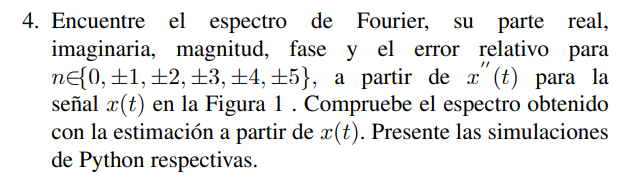

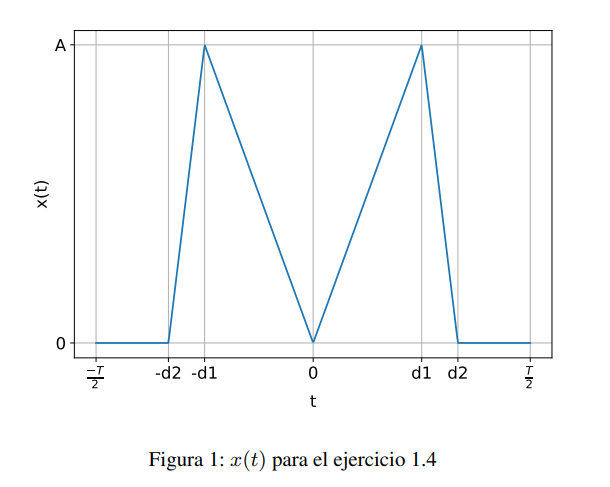

In [ ]:
# ===============================================================
# Espectro exponencial de Fourier de una señal triangular doble
# ===============================================================
# Señal como en la figura:
# - Periodo T (trabajamos en [-T/2, T/2))
# - Puntos: -d2 < -d1 < 0 < d1 < d2
# - x(±d2) = 0, x(0) = 0, x(±d1) = A
# - x(t) es PAR y LINEAL por tramos (dos triángulos por periodo)
#
# Objetivo:
#   1) c_n analítico usando x''(t) (Ejercicio 3).
#   2) c_n numérico integrando x(t) e^{-jn w0 t} (verificación).
#   3) Tabla con Re, Im, |.|, fase y errores relativos para n=-5..5.
#   4) Gráficas de |c_n| y ∠c_n.
#
# Requisitos:
#   pip install numpy matplotlib pandas
# (pandas solo para imprimir/guardar tabla más bonito; si no, se imprime con print)
# ===============================================================

import numpy as np
import matplotlib.pyplot as plt

# (pandas es opcional; el script corre sin él)
try:
    import pandas as pd
    PANDAS_OK = True
except Exception:
    PANDAS_OK = False

# -----------------------------
# PARÁMETROS EDITABLES
# -----------------------------
A  = 1.0     # altura en ±d1
T  = 1.0     # periodo
d1 = 0.15    # 0 < d1 < d2 < T/2
d2 = 0.35

assert 0.0 < d1 < d2 < (T/2), "Se requiere 0 < d1 < d2 < T/2"

w0 = 2*np.pi / T          # frecuencia fundamental
N_INT = 200_000           # muestras para la integración numérica (entre más, mejor)
N_MIN = -5                # armónico mínimo
N_MAX =  5                # armónico máximo

# -----------------------------
# UTILIDADES
# -----------------------------
def principal_interval(t):
    """
    Lleva t a u ∈ [-T/2, T/2) por equivalencia módulo T.
    Sirve para evaluar x(t) de manera periódica.
    """
    return (t + T/2) % T - T/2

# Pendientes de los tramos (usadas en la construcción de x(t))
alpha = A / (d2 - d1)   # pendiente en los tramos largos (0->A o A->0 en longitud d2-d1)
beta  = A / d1          # pendiente en los tramos cortos (0->A o A->0 en longitud d1)

def x_of_t(t):
    """
    Implementación fiel de la figura (por tramos):
      - 0 en [-T/2, -d2) y [d2, T/2)
      - lineal en [-d2, -d1]: sube 0 -> A
      - lineal en [-d1, 0]:  baja A -> 0
      - lineal en [0, d1]:   sube 0 -> A
      - lineal en [d1, d2]:  baja A -> 0
    Se extiende periódicamente al usar principal_interval.
    """
    u = principal_interval(np.array(t, dtype=float))
    y = np.zeros_like(u)

    # Tramo [-d2, -d1]: x = alpha * (u + d2)
    m = (u >= -d2) & (u < -d1)
    y[m] = alpha * (u[m] + d2)

    # Tramo [-d1, 0]: x = A - beta * (u + d1)
    m = (u >= -d1) & (u < 0)
    y[m] = A - beta * (u[m] + d1)

    # Tramo [0, d1]: x = beta * u
    m = (u >= 0) & (u < d1)
    y[m] = beta * u[m]

    # Tramo [d1, d2]: x = A - alpha * (u - d1)
    m = (u >= d1) & (u < d2)
    y[m] = A - alpha * (u[m] - d1)

    return y

def stem_simple(x, y, label=None):
    """
    Envoltorio de plt.stem SIN argumentos problemáticos (para compatibilidad amplia).
    Oculta la línea base.
    """
    markerline, stemlines, baseline = plt.stem(x, y, basefmt=" ")
    try:
        baseline.set_visible(False)
    except Exception:
        pass
    if label is not None:
        markerline.set_label(label)
    return markerline, stemlines, baseline

# -----------------------------
# 1) c_n ANALÍTICO DESDE x''(t)
# -----------------------------
def c_n_from_xpp(n):
    """
    Fórmula del Ej. 3 aplicada a esta señal.
    Para n != 0:
      c_n = -(2A)/(T (n w0)^2) * [ (cos(n w0 d2) - cos(n w0 d1))/(d2 - d1)
                                   + (1 - cos(n w0 d1))/d1 ]
    Para n = 0:
      c_0 = (1/T) * área_por_periodo = (A d2)/T (son dos triángulos de base d2 y altura A).
    """
    if n == 0:
        return (A * d2) / T
    term = ((np.cos(n*w0*d2) - np.cos(n*w0*d1)) / (d2 - d1)) + ((1 - np.cos(n*w0*d1)) / d1)
    c = - (2*A) / (T * (n*w0)**2) * term
    return c  # Para esta señal par, c_n es REAL.

# -----------------------------
# 2) c_n NUMÉRICO DESDE x(t)
# -----------------------------
def c_n_from_x_numeric(n, N=N_INT):
    """
    Aproxima c_n = (1/T) ∫_{-T/2}^{T/2} x(t) e^{-j n w0 t} dt
    mediante trapecios con N muestras uniformes.
    """
    t = np.linspace(-T/2, T/2, N, endpoint=False)
    x = x_of_t(t)
    kernel = np.exp(-1j * n * w0 * t)
    cn = (1.0 / T) * np.trapz(x * kernel, t)
    return cn

# -----------------------------
# 3) TABLA DE RESULTADOS
# -----------------------------
def tabla_resultados(n_min=N_MIN, n_max=N_MAX, eps=1e-12):
    rows = []
    for n in range(n_min, n_max + 1):
        c_ana = c_n_from_xpp(n)
        c_num = c_n_from_x_numeric(n)

        row = {
            "n": n,
            "Re{c_n} (x'')": float(np.real(c_ana)),
            "Im{c_n} (x'')": float(np.imag(c_ana)),
            "|c_n| (x'')": float(np.abs(c_ana)),
            "∠c_n (x'') [rad]": float(np.angle(c_ana)) if np.abs(c_ana) > eps else np.nan,
            "Re{c_n} (x) num": float(np.real(c_num)),
            "Im{c_n} (x) num": float(np.imag(c_num)),
            "|c_n| (x) num": float(np.abs(c_num)),
            "∠c_n (x) num [rad]": float(np.angle(c_num)) if np.abs(c_num) > eps else np.nan,
            "err_rel complex": float(np.abs(c_ana - c_num) / max(np.abs(c_num), eps)),
            "err_rel magnitude": float(abs(np.abs(c_ana) - np.abs(c_num)) / max(np.abs(c_num), eps)),
        }
        rows.append(row)

    if PANDAS_OK:
        df = pd.DataFrame(rows)
        print("\n=== Espectro — comparación analítica (x'') vs numérica (x) ===")
        print(df.to_string(index=False))
        # Guardar CSV opcional
        df.to_csv("espectro_xpp_vs_x.csv", index=False)
        print("\nCSV guardado: espectro_xpp_vs_x.csv")
    else:
        # Impresión básica sin pandas
        header = list(rows[0].keys())
        print("\n=== Espectro — comparación analítica (x'') vs numérica (x) ===")
        print(", ".join(header))
        for r in rows:
            print(", ".join(str(r[h]) for h in header))

# -----------------------------
# 4) GRÁFICAS DE |c_n| Y ∠c_n
# -----------------------------
def graficas(n_min=N_MIN, n_max=N_MAX, eps=1e-12):
    ns = np.arange(n_min, n_max + 1)
    mags = [abs(c_n_from_xpp(n)) for n in ns]
    phases = [np.angle(c_n_from_xpp(n)) if abs(c_n_from_xpp(n)) > eps else np.nan for n in ns]

    # Magnitud
    plt.figure()
    stem_simple(ns, mags)
    plt.title("Magnitud |c_n| (desde x'')")
    plt.xlabel("n"); plt.ylabel("|c_n|")
    plt.tight_layout(); plt.savefig("magnitud_cn.png"); plt.show()

    # Fase
    plt.figure()
    stem_simple(ns, phases)
    plt.title("Fase ∠c_n (desde x'')")
    plt.xlabel("n"); plt.ylabel("fase [rad]")
    plt.tight_layout(); plt.savefig("fase_cn.png"); plt.show()

    print("Figuras guardadas: magnitud_cn.png, fase_cn.png")

# -----------------------------
# 5) MAIN
# -----------------------------
if __name__ == "__main__":
    tabla_resultados()
    graficas()
